In [1]:
import os
import random

#data
import pandas as pd

# chemistry
import rdkit
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Lipinski

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# Machine learning
import sklearn
from sklearn import tree

Here I am training a Decision Tree model to classify if two pairs of ligands are suitable for template based docking:

1) The continuous rmsd values are divided into 2 classes: bellow 2.5 A and above 2.5 A

2) No values are considered inconclusive

3) Test set and training set don't have the same molecules

In [12]:
# get the data set
df = pd.read_csv('../data/train_test_rmsd_values_featurized_w_sasa_without_bad_pairs.csv')

In [31]:
levels_of_inconclusivity_dfs = []

for _df, dif in zip([df]*21 ,np.linspace(0,0.4,21)):
    # Assign binary labels to the dataset
    _df['binned_rmsd'] = None

    for index, rmsd in _df[['rmsd']].itertuples():
        if rmsd < 2.6:
            _df.at[index, 'binned_rmsd'] = 1
        elif 2.6 < rmsd < 2.6 + dif:
            _df.at[index, 'binned_rmsd'] = -1
        else:
            _df.at[index, 'binned_rmsd'] = 0

    _df = _df[_df['template']!=df['docked']]

    #_df = _df.loc[_df['binned_rmsd']!=-1].reset_index(drop=True)

    levels_of_inconclusivity_dfs += [_df]

In [32]:
df['binned_rmsd'] = None
# Features that will be used to classify:
not_features = ['template', 'docked', 'rmsd', 'uniprot_id', 'mcs_smartsString',
                'smiles_template', 'smiles_docked', 'binned_rmsd']
features = df.drop(columns=not_features).columns.tolist()
print(features)

['template_HeavyAtomCount', 'template_NHOHCount', 'template_NOCount', 'template_RingCount', 'template_NumHAcceptors', 'template_NumHDonors', 'template_NumHeteroAtoms', 'template_NumRotatableBonds', 'docked_HeavyAtomCount', 'docked_NHOHCount', 'docked_NOCount', 'docked_RingCount', 'docked_NumHAcceptors', 'docked_NumHDonors', 'docked_NumHeteroAtoms', 'docked_NumRotatableBonds', 'mcs_HeavyAtomCount', 'mcs_NOCount', 'mcs_RingCount', 'mcs_NumHeteroAtoms', 'mcs_template_NHOHCount', 'mcs_docked_NHOHCount', 'mcs_template_NumHAcceptors', 'mcs_docked_NumHAcceptors', 'mcs_template_NumHDonors', 'mcs_docked_NumHDonors', 'mcs_template_NumRotatableBonds', 'mcs_docked_NumRotatableBonds', 'ec_tanimoto_similarity', 'fc_tanimoto_similarity', 'mcs_bonded_polar_sasa', 'mcs_bonded_apolar_sasa', 'mcs_unbonded_polar_sasa', 'mcs_unbonded_apolar_sasa', 'sasa_bonded_polar', 'sasa_bonded_apolar', 'sasa_unbonded_polar', 'sasa_unbonded_apolar', 'group']


In [33]:
groups = []
size_of_groups = {}
for group in df['group'].drop_duplicates():
    groups +=  [group]
    size_of_groups[group] = df[df['group']==group].shape[0]

print(size_of_groups)

{1: 7399, 2: 4296, 5: 788, 6: 1053, 9: 408, 10: 695, 11: 593, 12: 260, 14: 2, 15: 94, 17: 5, 18: 119, 19: 504, 20: 2, 21: 483, 22: 313, 23: 248, 24: 222, 25: 324, 26: 314, 27: 39, 28: 199, 29: 218, 30: 93, 32: 13, 33: 190, 34: 162, 37: 3, 38: 55, 39: 92, 40: 76, 41: 89, 42: 84, 43: 103, 44: 116, 45: 48, 47: 74, 48: 11, 49: 17, 52: 6, 53: 45, 55: 2, 56: 37, 57: 48, 58: 22, 59: 7, 60: 7, 61: 11, 62: 20, 63: 8, 65: 11, 66: 2, 67: 5, 69: 8, 70: 2, 71: 2, 72: 2, 73: 2, 74: 4, 75: 4, 76: 1, 77: 6}


In [34]:
def check_sizes_of_folds(folds):
    sizes = []
    for fold in folds:
        sizes += [sum([size_of_groups[g] for g in fold])]
    return sizes

In [35]:
k = 4

base_size = len(groups)//(k)
base_rest = len(groups)%(k)

print(base_size, base_rest)

list_of_folds = []
for number in range(5):

    random.shuffle(groups)
    folds = [groups[i*base_size:(i+1)*base_size] for i in range(k)]

    for i in range(base_rest):
        folds[-(i+1)] = np.append(groups[-(i+1)], folds[-(i+1)])

    print(check_sizes_of_folds(folds))

    list_of_folds += [folds]

levels_train_test_folds_dfs = []
for _df in levels_of_inconclusivity_dfs:
    train_test_folds_dfs = []
    for folds in list_of_folds:
        folds_dfs = [[]]
        for fold in folds:
            for group in fold:
                folds_dfs[-1] += [_df.loc[_df['group']==group]]
            folds_dfs[-1] = pd.concat(folds_dfs[-1])
            folds_dfs += [[]]

        _train_test_folds_dfs = []
        for i in range(k):
            _train_test_folds_dfs += [[]]
            _train_test_folds_dfs[-1] += [pd.concat([folds_dfs[j] for j in range(k) if j!=i])]
            _train_test_folds_dfs[-1][-1] = _train_test_folds_dfs[-1][-1].loc[_train_test_folds_dfs[-1][-1]['binned_rmsd']!=-1]
            _train_test_folds_dfs[-1] += [folds_dfs[i]]
            _train_test_folds_dfs[-1][-1].loc[_train_test_folds_dfs[-1][-1]['rmsd']>3, 'binned_rmsd'] = 0
            _train_test_folds_dfs[-1][-1].loc[_train_test_folds_dfs[-1][-1]['rmsd']<2, 'binned_rmsd'] = 1
            _train_test_folds_dfs[-1][-1] = _train_test_folds_dfs[-1][-1].loc[(_train_test_folds_dfs[-1][-1]['rmsd']<2) |
                                                                              (_train_test_folds_dfs[-1][-1]['rmsd']>3)]

        train_test_folds_dfs += _train_test_folds_dfs

    levels_train_test_folds_dfs += [train_test_folds_dfs]

print('done!')

15 2
[7471, 2679, 1136, 8780]
[1429, 2933, 14041, 1663]
[2254, 2403, 1721, 13688]
[8979, 2881, 5995, 2211]
[1604, 3636, 12925, 1901]
done!


In [36]:
clf = tree.DecisionTreeClassifier(max_depth=6, class_weight="balanced")

In [37]:
recall = []
precision = []
auc = []
for i in range(len(levels_of_inconclusivity_dfs)):
    recall += [[]]
    precision += [[]]
    auc += [[]]
    for train, test in levels_train_test_folds_dfs[i]:
        _feats_train = train.drop(columns=not_features + ['group']).values.tolist()
        _labels_train = train[['binned_rmsd']].values.tolist()
        clf = clf.fit(_feats_train, _labels_train)
        _feats_test = test.drop(columns=not_features + ['group']).values.tolist()
        _labels_test = test[['binned_rmsd']].values.tolist()
        recall[-1] += [sklearn.metrics.recall_score(_labels_test, clf.predict(_feats_test))]
        precision[-1] += [sklearn.metrics.precision_score(_labels_test, clf.predict(_feats_test))]
        auc[-1] += [sklearn.metrics.roc_auc_score(_labels_test, clf.predict_proba(_feats_test)[:,1])]
    recall[-1] = np.mean(recall[-1])
    auc[-1] = np.mean(auc[-1])
    precision[-1] = np.mean(precision[-1])

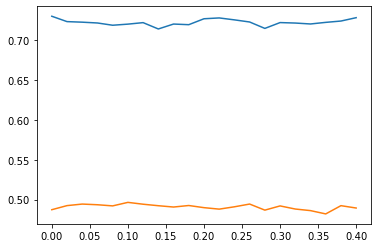

In [38]:
x = np.linspace(0,0.4,21)
plt.plot(x,recall)
plt.plot(x,precision)
plt.show()

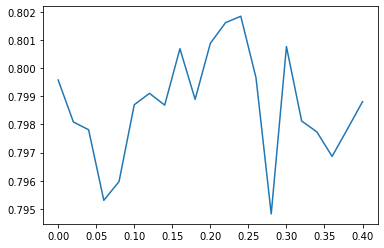

In [39]:
plt.plot(x,auc)
plt.show()

In [172]:
from sklearn import inspection

rr = []
for train, test in train_test:

    _feats_train = train.drop(columns=not_features + ['group']).values.tolist()
    _labels_train = train[['binned_rmsd']].values.tolist()
    _feats_test = test.drop(columns=not_features + ['group']).values.tolist()
    _labels_test = test[['binned_rmsd']].values.tolist()

    clf = clf.fit(_feats_train, _labels_train)

    r = inspection.permutation_importance(clf, _feats_test, _labels_test,
                                      scoring=sklearn.metrics.make_scorer(sklearn.metrics.roc_auc_score),
                                      n_repeats=100,
                                      n_jobs=-1)
    rr += [r]

r = {'importances_mean': 0,
     'importances_std': 0}
for i in rr:
    r['importances_mean'] += i['importances_mean']/len(rr)
    r['importances_std'] += i['importances_std']/len(rr)

for i in r['importances_mean'].argsort()[::-1]:
    if r['importances_mean'][i] - 2 * r['importances_std'][i] > 0:
        print(f"{features[i]:<30}"
              f"{r['importances_mean'][i]:.3f}"
              f" +/- {r['importances_std'][i]:.3f}")

ec_tanimoto_similarity        0.112 +/- 0.007
mcs_unbonded_polar_sasa       0.030 +/- 0.003
mcs_bonded_apolar_sasa        0.026 +/- 0.005
fc_tanimoto_similarity        0.016 +/- 0.003
mcs_RingCount                 0.009 +/- 0.003
docked_HeavyAtomCount         0.009 +/- 0.004
mcs_NumHeteroAtoms            0.007 +/- 0.001
mcs_HeavyAtomCount            0.005 +/- 0.001
sasa_bonded_apolar            0.003 +/- 0.001
mcs_docked_NumHDonors         0.002 +/- 0.001
mcs_template_NumHAcceptors    0.002 +/- 0.001
mcs_NOCount                   0.001 +/- 0.000
template_NumRotatableBonds    0.001 +/- 0.000


In [88]:
for train, test in train_test:
    train['dt_score'] = None
    test['dt_score'] = None

top = 3
range_of_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
proportion_top = []
range_of_top = [1,2,3,4,5,6,7,8,9,10]
proportion_thresh = []
valids_thresh = []
for train, test in train_test:
    _feats_train = train.drop(columns=not_features + ['group', 'dt_score']).values.tolist()
    _labels_train = train[['binned_rmsd']].values.tolist()
    _feats_test = test.drop(columns=not_features + ['group', 'dt_score']).values.tolist()
    clf = clf.fit(_feats_train, _labels_train)
    test['dt_score'] = clf.predict_proba(_feats_test)[:,1]
    _proportion = []
    for i in range_of_top:
        count = 0
        for docked in test['docked'].drop_duplicates().values:
                if test.loc[(test['docked']==docked)] \
                                     .sort_values(by=['dt_score'], ascending=False)[:i] \
                                     .loc[test['rmsd']<2].shape[0] > 0:
                    count += 1
        _proportion += [count/test['docked'].drop_duplicates().shape[0]]
    proportion_top += [_proportion]

    _proportion = []
    _valids = []
    for i in range_of_thresholds:
        count = 0
        valid = 0
        for docked in test['docked'].drop_duplicates().values:
            if test.loc[(test['docked']==docked)
                                      & (test['dt_score']>i)].shape[0] > 0:
                valid += 1
                if test.loc[(test['docked']==docked) & (test['dt_score']>i)] \
                                     .sort_values(by=['dt_score'], ascending=False)[:top] \
                                     .loc[test['rmsd']<2].shape[0] > 0:
                    count += 1
        _valids += [valid/test['docked'].drop_duplicates().shape[0]]
        _proportion += [count/valid]
    proportion_thresh += [_proportion]
    valids_thresh += [_valids]


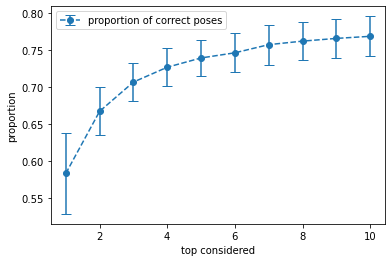

In [93]:
mean_proportion_top = []
std_proportion_top = []
for i in range(len(range_of_top)):
    mean_proportion_top += [np.mean(np.array(proportion_top)[:,i])]
    std_proportion_top += [np.std(np.array(proportion_top)[:,i])]

plt.errorbar(range_of_top, mean_proportion_top, yerr=std_proportion_top, capsize=5, fmt='--o', label='proportion of correct poses')
plt.xlabel('top considered')
plt.ylabel('proportion')
plt.legend()
plt.show()

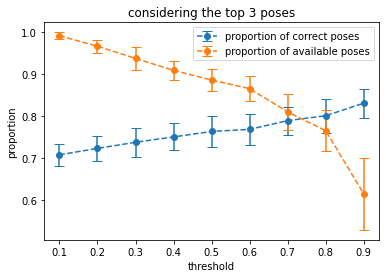

In [91]:
mean_proportion_thresh = []
mean_valids_thresh = []
std_proportion_thresh = []
std_valids_thresh = []
for i in range(len(range_of_thresholds)):
    mean_proportion_thresh += [np.mean(np.array(proportion_thresh)[:,i])]
    mean_valids_thresh += [np.mean(np.array(valids_thresh)[:,i])]
    std_proportion_thresh += [np.std(np.array(proportion_thresh)[:,i])]
    std_valids_thresh += [np.std(np.array(valids_thresh)[:,i])]

plt.errorbar(r, mean_proportion_thresh, yerr=std_proportion_thresh, capsize=5, fmt='--o', label='proportion of correct poses')
plt.errorbar(r, mean_valids_thresh, yerr=std_valids_thresh, capsize=5, fmt='--o', label='proportion of available poses')
plt.xlabel('threshold')
plt.ylabel('proportion')
plt.title('considering the top '+str(top)+' poses')
plt.legend()
plt.show()